In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, model_from_json
from keras.layers import LSTM, Bidirectional, Dense, Dropout
# from keras.preprocessing.sequence import TimeseriesGenerator
import FinanceDataReader as fdr

In [2]:
code = '005930'
date_start = '2016-09-02'
raw_df = fdr.DataReader(code, date_start)
#raw_df = pd.read_csv('Analysis/005930.KS.csv')
# raw_df.head()
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1231 entries, 2016-09-02 to 2021-09-03
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1231 non-null   int64  
 1   High    1231 non-null   int64  
 2   Low     1231 non-null   int64  
 3   Close   1231 non-null   int64  
 4   Volume  1231 non-null   int64  
 5   Change  1231 non-null   float64
dtypes: float64(1), int64(5)
memory usage: 67.3 KB


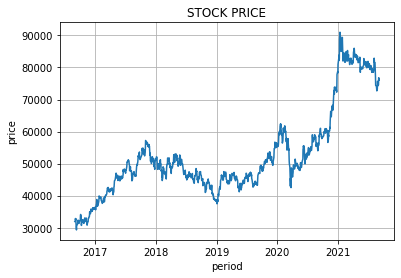

In [3]:
plt.title('STOCK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['Close'], label='Close')

plt.show()

In [4]:
# 통계정보 확인
raw_df.describe()

Open          High           Low         Close        Volume  \
count   1231.000000   1231.000000   1231.000000   1231.000000  1.231000e+03   
mean   52509.471162  53038.484159  51994.406174  52637.522340  1.103526e+07   
std    14031.393158  14144.793492  13912.395185  13755.916219  1.075829e+07   
min        0.000000      0.000000      0.000000  29300.000000  0.000000e+00   
25%    44500.000000  45000.000000  44125.000000  44665.000000  2.821795e+05   
50%    48900.000000  49300.000000  48300.000000  48880.000000  1.000253e+07   
75%    56380.000000  56960.000000  55810.000000  56400.000000  1.650665e+07   
max    90300.000000  96800.000000  89500.000000  91000.000000  9.030618e+07   

            Change  
count  1231.000000  
mean      0.000857  
std       0.016896  
min      -0.080357  
25%      -0.008642  
50%       0.000717  
75%       0.010239  
max       0.104706

In [5]:
# Missing Data 확인
raw_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
Change    0
dtype: int64

In [6]:
# 최소값이 0인 column 체크
for col in raw_df.columns:
    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Open <class 'str'>
High <class 'str'>
Low <class 'str'>
Volume <class 'str'>


In [7]:
# 먼저 0 을 NaN으로 바꾼후, Missing Data 처리
raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

In [8]:
# raw_df['Date'] = pd.to_datetime(raw_df['Date'])
# raw_df.set_axis(raw_df['Date'], inplace=True)
raw_df.drop(columns=['Open', 'High', 'Low', 'Change', 'Volume'], inplace=True)
raw_df.dropna(inplace=True)
raw_df

Close
Date             
2016-09-02  31940
2016-09-05  32120
2016-09-06  32860
2016-09-07  32420
2016-09-08  32780
...           ...
2021-08-30  74600
2021-08-31  76700
2021-09-01  76800
2021-09-02  76000
2021-09-03  76500

[1231 rows x 1 columns]

In [9]:
# 정규화 (Date 제외한 모든 수치부분 정규화)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
scaled_df = scaler.fit_transform(raw_df['Close'].values.reshape(-1,1))
# scaled_df = pd.DataFrame(scaled_df, columns=scale_cols)
scaled_df.shape

(1231, 1)

In [10]:
###### 학습데이터, 테스트데이터 생성
# close_data = raw_df['Close'].values
# close_data = close_data.reshape((-1,1))
close_data = scaled_df

# split_percent = 0.80
# split = int(split_percent*len(close_data))

# close_train = close_data[:split]
# close_test = close_data[split:]

# date_train = raw_df.index[:split]
# date_test = raw_df.index[split:]

# print(len(close_train))
# print(len(close_test))

In [11]:
look_back = 50
seq_len = look_back+1

result = []
for i in range(len(close_data) - seq_len):
    result.append(close_data[i: i+seq_len])
result = np.array(result)
result = result.reshape(result.shape[0], result.shape[1], -1)

In [12]:
split_percent = 0.80
split = int(split_percent*result.shape[0])
train = result[:split, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:, -1]

x_test = result[split:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = result[split:, -1]

date_train = raw_df.index[:split]
date_test = raw_df.index[split:]

x_train.shape, x_test.shape

((944, 50, 1), (236, 50, 1))

In [13]:
# look_back = 20

# train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=16)
# test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [14]:
# 모델 구축 및 컴파일
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu', return_sequences=True), input_shape=(look_back,1)))
model.add(Bidirectional(LSTM(64, return_sequences=False)))
model.add(Dense(1, activation='linear'))
# sgd = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False)
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 50, 100)           20800     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               84480     
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 105,409
Trainable params: 105,409
Non-trainable params: 0
_________________________________________________________________


In [15]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

num_epochs = 10
h5 = 'Analysis/Bi-LSTM-{}-{}-trial-001.h5'.format(code, date_start)
checkpoint = ModelCheckpoint(h5,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             save_weights_only=True,
                             mode='auto')

early_stop = EarlyStopping(monitor='val_loss',
                           patience=10)

json = 'Analysis/Bi-LSTM-{}-{}-trial-001.json'.format(code, date_start)
model_json = model.to_json()
with open(json, 'w') as json_file:
    json_file.write(model_json)

model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=num_epochs,
          batch_size=10,  shuffle=False, callbacks=[checkpoint, early_stop])

Epoch 1/10
95/95 [==============================] - 6s 32ms/step - loss: 0.0044 - val_loss: 0.0319

Epoch 00001: val_loss improved from inf to 0.03188, saving model to Analysis\Bi-LSTM-005930-2016-09-02-trial-001.h5
Epoch 2/10
95/95 [==============================] - 2s 26ms/step - loss: 0.0060 - val_loss: 0.0525

Epoch 00002: val_loss did not improve from 0.03188
Epoch 3/10
95/95 [==============================] - 2s 25ms/step - loss: 0.0029 - val_loss: 0.0174

Epoch 00003: val_loss improved from 0.03188 to 0.01744, saving model to Analysis\Bi-LSTM-005930-2016-09-02-trial-001.h5
Epoch 4/10
95/95 [==============================] - 2s 26ms/step - loss: 0.0017 - val_loss: 0.0015

Epoch 00004: val_loss improved from 0.01744 to 0.00149, saving model to Analysis\Bi-LSTM-005930-2016-09-02-trial-001.h5
Epoch 5/10
95/95 [==============================] - 2s 26ms/step - loss: 0.0012 - val_loss: 0.0021

Epoch 00005: val_loss did not improve from 0.00149
Epoch 6/10
95/95 [========================

In [16]:
# def load_keras_model(json, h5, optimizer):
#     json_file = open(json, 'r')
#     loaded_model_json = json_file.read()
#     json_file.close()
#     model = model_from_json(loaded_model_json)
#     model.compile(optimizer=optimizer, loss='mse')
#     model.load_weights(h5)
#     return model
# model = load_keras_model('Analysis/Bi-LSTM-005930-2016-09-02-trial-001.json',
#                          'Analysis/Bi-LSTM-005930-2016-09-02-trial-001.h5',
#                          'adam')

In [17]:
# 모델 학습(EarlyStopping 적용)
# from keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', patience=5)

# model.fit(x_train, y_train,
#          validation_data=(x_test, y_test),
#          epochs=100, batch_size=16,
#          callbacks=[early_stop])

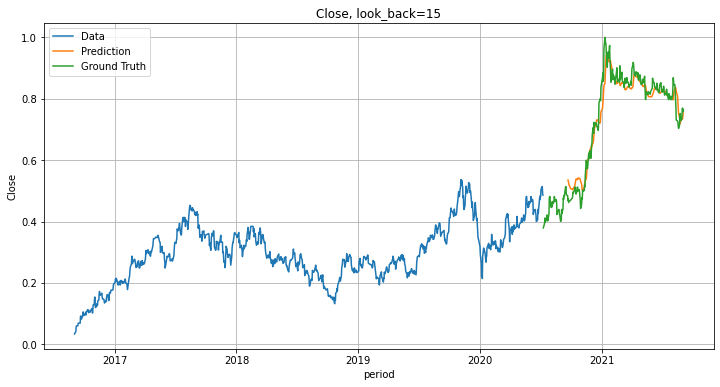

In [18]:
prediction = model.predict(x_test)
close_data = close_data.reshape((-1))
truth_data = close_data[-len(date_test):]

# close_train = close_train.reshape((-1))
# close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

plt.figure(figsize=(12, 6))
plt.title('Close, look_back=15')
plt.ylabel('Close')
plt.xlabel('period')
plt.plot(date_train, y_train, label='Data')
plt.plot(date_test[look_back+1:], prediction, label='Prediction')
plt.plot(date_test, truth_data, label='Ground Truth')
plt.grid()
plt.legend(loc='best')

plt.show()

In [19]:
# 평균절대값백분율오차계산 (MAPE)
print(np.sum(abs(truth_data[look_back+1:]-prediction)/truth_data[look_back+1:]) /len(truth_data[look_back+1:]))
accuracy = 100 - (np.sum(abs(truth_data[look_back+1:]-prediction)/truth_data[look_back+1:]) /len(truth_data[look_back+1:]))*100
print('정확도: ', round(accuracy,2), '%')

0.03427637842956121
정확도:  96.57 %


In [20]:
# close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
    
    return prediction_list

def predict_dates(num_prediction):
    last_date = raw_df.index.values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

In [21]:
valueee = scaler.inverse_transform(forecast.reshape(-1,1))
valueee[1]

array([76258.51995945])

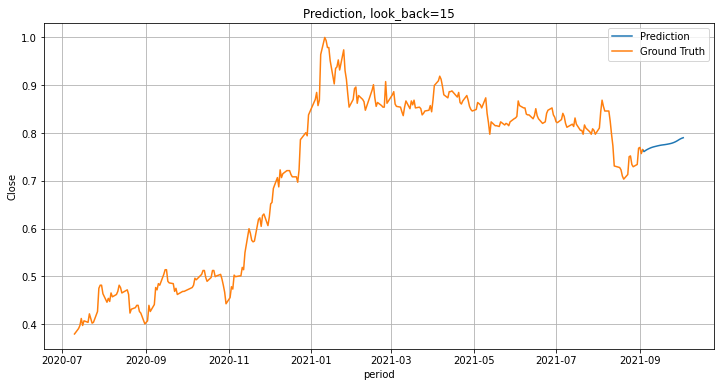

In [22]:
plt.figure(figsize=(12, 6))
plt.title('Prediction, look_back=15')
plt.ylabel('Close')
plt.xlabel('period')
# plt.plot(date_train, close_train, label='Data')
plt.plot(forecast_dates, forecast, label='Prediction')
plt.plot(date_test, truth_data, label='Ground Truth')
plt.grid()
plt.legend(loc='best')

plt.show()